## Importing the required libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

## Reading the dataset as pandas dataframe and splitting it into train and test

In [2]:
df=pd.read_csv('iris.csv') #reading the dataset
train_df,test_df=train_test_split(df,random_state=0) #splitting the dataset into train and test

## Checking if the data is pure or not i.e. it contains only one class

In [3]:
def is_pure(df):
    unique_values=len(np.unique(df.iloc[:,-1])) #finding the length of unique classes in the data
    if unique_values==1: #if length of unique classes is 1, the data is pure and it contains only one class
        return True
    return False

## Classifying the data - finding the majority class in the data (the class having maximum data points)

In [4]:
def classify(df):
    species,counts=np.unique(df.iloc[:,-1],return_counts=True) #finding the unique classes and their count in data
    index=np.argmax(counts) # finding the index of the class which has maximum count
    return species[index]  #returning the class with mamximum count

## Finding the potential splits (the values on which we can perform split)

In [6]:
def get_potential_splits(df):
    potential_splits={} # this dictionary contains columns number as key and a list containing potential splits as value
    columns=df.columns
    for j in range(len(columns)-1):
        column_values=np.unique(df[columns[j]].values) #finding unique values in a column j
        potential_splits[j]=[]
        for i in range(1,len(column_values)):
            potential_splits[j].append((column_values[i]+column_values[i-1])/2) #finding all potential splits for column j
    return potential_splits 

In [7]:
potential_splits=get_potential_splits(train_df) #getting potential splits

## Splitting the data points on the basis of potential split of a particular column

In [8]:
def split(df,split_column,split_value):
    columns=df.columns
    left_df=df[df[columns[split_column]]<=split_value] #getting the data points in which column values are less than or equal to split value
    right_df=df[df[columns[split_column]]>split_value] #getting the data points in which column values are greater than split value
    return left_df,right_df 

## Calculating entropy of data points

In [9]:
def calculate_entropy(df):
    counts=np.unique(df.iloc[:,-1],return_counts=True)[1] #getting counts of all the classes in the data
    probabilities=counts/counts.sum() #finding probability of each data points
    entropy=(-probabilities*np.log(probabilities)).sum() #calculating entropy
    return entropy #returning entropy

## Calculating gain ratio

In [10]:
def calculate_gain_ratio(df,left_df,right_df):
    entropy_left=calculate_entropy(left_df) #getting entropy of data points which are in left half
    entropy_right=calculate_entropy(right_df) #getting entropy of data points which are in right half
    d1=len(left_df)
    d2=len(right_df)
    d=d1+d2
    entropy_before=calculate_entropy(df) #calculating data points before split
    entropy_after=(d1/d)*entropy_left+(d2/d)*entropy_right #calculating overall entropy after split
    info_gain=entropy_before-entropy_after #calculating information gain
    split_info=-(d1/d)*np.log(d1/d)-d2/d*np.log(d2/d) #calculating split info
    gain_ratio=info_gain/split_info #calculating gain ratio
    return gain_ratio

## Getting best split (finding the column number and split value of that column on which if data is splitted then the gain ratio is maximum)

In [11]:
def get_best_split(df,potential_splits):
    potential_splits=get_potential_splits(df) # getting potential splits
    max_gain_ratio=-1 # it holds the maximum gain ratio
    best_split_column=-1 #it holds the best column number on which gain ratio is maximum when splitted
    best_split_value=-1 #it holds the best split value on which gain ratio is maximum when splitted
    for column in potential_splits:
        for split_value in potential_splits[column]:
            left_df,right_df=split(df,column,split_value) #splitting the data points
            gain_ratio=calculate_gain_ratio(df,left_df,right_df) #finding gain ratio for a particular split
            if gain_ratio>max_gain_ratio: #finding the maximum gain ratio
                max_gain_ratio=gain_ratio
                best_split_value=split_value
                best_split_column=column
    return best_split_column,best_split_value,max_gain_ratio   

## Printing the decision tree steps and building actual decision tree (getting a dictionary which contains at each level, on which feature and on which value the data should be splitted)

In [12]:
def fit(df,potential_split,level,max_level=3):
    if level>0:
        print()
    if len(df)==0:
        return None
    print('Level', level)
    species,counts=np.unique(df.iloc[:,-1],return_counts=True)
    #printing the decision tree in the required format
    for i in range(len(species)):
        print('Count of',species[i],'=',counts[i]) #printing unique classes in data points and its counts
    current_entropy=calculate_entropy(df) #finding current entropy for each data points
    print('Current Entropy is',current_entropy)
    if is_pure(df) or level==max_level: #if data point is pure i.e. only one class is present or maximum level is reached, predicting the class based on majority votes
        print('Reached Leaf Node')
        return classify(df)
    else:
        best_split_column,best_split_value,max_gain_ratio=get_best_split(df,potential_splits) #finding the split column and split value for which gain ratio is maximum
        feature_name=df.columns[best_split_column]
        tree_dict={}
        key=str(feature_name)+'  <= '+str(best_split_value)
        tree_dict[key]=[]
        print('Splitting on feature ',feature_name,'with gain ratio ',max_gain_ratio)
        left_df,right_df=split(df,best_split_column,best_split_value)
        left_dict=fit(left_df,potential_split,level+1)
        right_dict=fit(right_df,potential_split,level+1)
        if not left_dict is None:
            tree_dict[key].append(left_dict)
        if not right_dict is None:
            tree_dict[key].append(right_dict)
        return tree_dict    

In [13]:
# printing the steps of decision tree and storing the actual decision tree as a dictionary
tree_dict=fit(train_df,potential_splits,0)

Level 0
Count of setosa = 37
Count of versicolor = 34
Count of virginica = 41
Current Entropy is 1.0956714129052516
Splitting on feature  petal_length with gain ratio  1.0

Level 1
Count of setosa = 37
Current Entropy is 0.0
Reached Leaf Node

Level 1
Count of versicolor = 34
Count of virginica = 41
Current Entropy is 0.6887852792452958
Splitting on feature  petal_length with gain ratio  0.7064313543656207

Level 2
Count of versicolor = 33
Count of virginica = 3
Current Entropy is 0.2868359830561607
Splitting on feature  petal_width with gain ratio  0.643158422044091

Level 3
Count of versicolor = 32
Current Entropy is 0.0
Reached Leaf Node

Level 3
Count of versicolor = 1
Count of virginica = 3
Current Entropy is 0.5623351446188083
Reached Leaf Node

Level 2
Count of versicolor = 1
Count of virginica = 38
Current Entropy is 0.11924692639624491
Splitting on feature  petal_length with gain ratio  0.1861963514259986

Level 3
Count of versicolor = 1
Count of virginica = 3
Current Entropy 

In [14]:
#printing the actual decision tree
tree_dict

{'petal_length  <= 2.35': ['setosa',
  {'petal_length  <= 4.95': [{'petal_width  <= 1.65': ['versicolor',
      'virginica']},
    {'petal_length  <= 5.05': ['virginica', 'virginica']}]}]}

In [20]:
#predicing the class for a given single data point
def predict_single_data_point(tree_dict,data):
    key=list(tree_dict.keys())[0]
    feature_name,_,value=key.split()
    current_value=data[feature_name]
    if current_value<=float(value):
        residual_dict=tree_dict[key][0]
    else:
        residual_dict=tree_dict[key][1]
    residual_dict    
    if isinstance(residual_dict,dict):
        return predict_single_data_point(residual_dict,data)
    else:
        return residual_dict

In [21]:
#predicting the class for all the data points
def predict_all_data_points(tree_dict,test_df):
    y_pred=[]
    for i in range(len(test_df)):
        y_pred.append(predict_single_data_point(tree_dict,test_df.iloc[i]))
    return y_pred    

## Checking performance of decision tree through confusion matrix and classification report

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


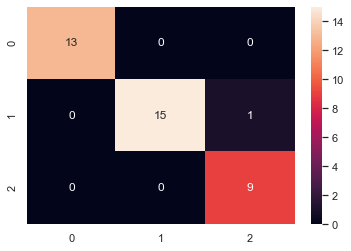

In [32]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
y_pred=predict_all_data_points(tree_dict,test_df)
y_test=test_df['species']
cm=confusion_matrix(y_test,y_pred) #getting confusion matrix
print(cm) #printing confusion matrix
sns.heatmap(cm,annot=True) #plotting confusion matrix
plt.show()

In [42]:
print('Accuracy of decision tree:',"{:.2%}".format(accuracy_score(y_test,y_pred)))

Accuracy of decision tree: 97.37%


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred)) #printing classification report

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

